imports:

In [65]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

from enum import IntEnum
from typing import List

In [167]:
class POS(IntEnum):
    """
    Enum representing part of speech tags. Types are defined on this webpage:
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    Note that:
    - SYMB is any symbol
    - WPS is WP$ (possessive wh-pronoun)
    - PRPS is PRP$ (possessive pronoun)
    - HYPH is a literal hyphen
    - QUOT is a quote (`` or '')
    - I don't know what XX is supposed to be
    - I don't knwo what NFP is supposed to be
    - I don't knwo what ADD is supposed to be
    - I don't knwo what AFX is supposed to be
    """
    CC	   = 26
    CD	   = 34
    DT	   = 3
    EX	   = 2
    FW	   = 30
    IN	   = 17
    JJ	   = 25
    JJR	   = 24
    JJS	   = 23
    LS	   = 33
    MD	   = 27
    NN	   = 36
    NNS	   = 35
    NNP	   = 37
    NNPS   = 1
    PDT	   = 7
    POS	   = 10
    PRP	   = 5
    PRPS   = 4
    RB	   = 19
    RBR	   = 20
    RBS	   = 21
    RP	   = 18
    SYM	   = 31
    TO	   = 17
    UH	   = 29
    VB	   = 12
    VBD	   = 11
    VBG	   = 13
    VBN	   = 16
    VBP	   = 14
    VBZ	   = 15
    WDT	   = 6
    WP	   = 4
    WPS	   = 8
    WRB	   = 22
    HYPH   = 32
    QUOT   = 38
    XX     = 39
    PERIOD = 40
    COMMA  = 41
    COLON  = 42
    NFP    = 43
    ADD    = 44
    AFX    = 45

    @staticmethod
    def from_str(s):
        """
        Obtain a POS tag from a string s, if it represents a valid POS type.
        """
        if s == "CC":         return POS.CC
        if s == "CD":         return POS.CD
        if s == "DT":         return POS.DT
        if s == "EX":         return POS.EX 
        if s == "FW":         return POS.FW
        if s == "IN":         return POS.IN
        if s == "JJ":         return POS.JJ
        if s == "JJR":        return POS.JJR
        if s == "JJS":        return POS.JJS
        if s == "LS":         return POS.LS
        if s == "MD":         return POS.MD
        if s == "NN":         return POS.NN
        if s == "NNS":        return POS.NNS
        if s == "NNP":        return POS.NNP
        if s == "NNPS":       return POS.NNPS
        if s == "PDT":        return POS.PDT
        if s == "POS":        return POS.POS
        if s == "PRP":        return POS.PRP
        if s == "PRP$":       return POS.PRPS
        if s == "RB":         return POS.RB
        if s == "RBR":        return POS.RBR
        if s == "RBS":        return POS.RBS
        if s == "RP":         return POS.RP
        if s == "SYM":        return POS.SYM
        if s == "TO":         return POS.TO
        if s == "UH":         return POS.UH
        if s == "VB":         return POS.VB
        if s == "VBD":        return POS.VBD
        if s == "VBG":        return POS.VBG
        if s == "VBN":        return POS.VBN
        if s == "VBP":        return POS.VBP
        if s == "VBZ":        return POS.VBZ
        if s == "WDT":        return POS.WDT
        if s == "WP":         return POS.WP
        if s == "WP$":        return POS.WPS
        if s == "WRB":        return POS.WRB
        if s == "HYPH":       return POS.HYPH
        if s == "XX":         return POS.XX
        if s == "NFP":        return POS.NFP
        if s == "ADD":        return POS.ADD
        if s == "AFX":        return POS.AFX
        if s == ".":          return POS.PERIOD
        if s == ",":          return POS.COMMA
        if s == ":":          return POS.COLON
        if s in ["$"]:        return POS.SYM
        if s in ["``", "''"]: return POS.QUOT 
        raise ValueError("No POS tag with value \"" + s + "\".")


class Sentence:
    """
    Class for representing a sentence as a list of POS tags and its original
    text
    """
    def __init__(self, morph: List[POS], text: str):
        self.morph = morph
        self.text = text

    def vectorize(self):
        return [ int(tag) for tag in self.morph ]

    def __str__(self):
        return f"Sentence({self.morph}, \"{self.text}\")"

    def __repr__(self):
        return f"Sentence({self.morph}, \"{self.text}\")"

In [168]:
def get_sentences_from_json(filename: str) -> List[Sentence]:
    with open(filename, 'r') as file:
        return [ Sentence(text=s["text"],
                          morph=list(map(lambda x: POS.from_str(x),
                                         s["morphology"].split(" "))))
                 for s in json.load(file) ]

def get_centered_vectors(s: Sentence, size: int) -> List[Sentence]:
    """
    From a sentence s, get vectors centered around adverbial particles (RP's).

    @param size The number of words to capture surrounding the RP -- if there
                are not enough words around the RP to capture, do not create 
                such vector.
    """
    res = []
    # Only pad the sentence with one UH -- if you pad with too many UH's then
    # you have unreasonably long sentences
    padded_sentence = [POS.UH] + s.morph + [POS.UH]
    for i, tag in enumerate(s.morph): 
        # TODO: we cannot actually pad anything! padding makes it wrong!
        if tag == POS.RP:
            bounds = [i-size+1, i+size+2]
            if bounds[0] < 0 or bounds[1] >= len(padded_sentence):
                continue
            # Giving +1 and -1 to text bounds because splitting by space is not accurate
            text = " ".join(s.text.split(" ")[bounds[0]-1:bounds[1]+1])
            res.append(Sentence(padded_sentence[bounds[0]:bounds[1]], text))
    return res


def get_centered_vectors_from_sentences(sentences: List[Sentence], size:int) -> List[Sentence]:
    """
    From a list of sentences, obtain all vectors centered around an adverbial particle
    with a certain window size
    """
    return [ v for s in sentences for v in get_centered_vectors(s, size) ]

In [169]:
sentences_src = get_sentences_from_json("CleanedDataRPnoSyntax.json")

centered_vectors = []
for size in range(1,14):
    centered_vectors.append(get_centered_vectors_from_sentences(sentences_src, size))

In [170]:
centered_vectors[2]

[Sentence([<POS.IN: 17>, <POS.RB: 19>, <POS.VB: 12>, <POS.RP: 18>, <POS.NN: 36>, <POS.NNS: 35>, <POS.IN: 17>], "than just send out marketing people to knock on"),
 Sentence([<POS.NN: 36>, <POS.CC: 26>, <POS.VBD: 11>, <POS.RP: 18>, <POS.IN: 17>, <POS.PRPS: 4>, <POS.VBD: 11>], "and stood up for what was right, should have"),
 Sentence([<POS.NN: 36>, <POS.CC: 26>, <POS.VB: 12>, <POS.RP: 18>, <POS.PRPS: 4>, <POS.JJ: 25>, <POS.NN: 36>], "justice and bring out their full flavour."),
 Sentence([<POS.UH: 29>, <POS.CC: 26>, <POS.VB: 12>, <POS.RP: 18>, <POS.DT: 3>, <POS.NNS: 35>, <POS.NN: 36>], ""),
 Sentence([<POS.NNP: 37>, <POS.NN: 36>, <POS.VBN: 16>, <POS.RP: 18>, <POS.IN: 17>, <POS.DT: 3>, <POS.NNP: 37>], "put forth at this Customs Directors Conference."),
 Sentence([<POS.COMMA: 41>, <POS.VBG: 13>, <POS.PRP: 5>, <POS.RP: 18>, <POS.IN: 17>, <POS.DT: 3>, <POS.DT: 3>], "sealing it off from the the rest of the"),
 Sentence([<POS.NN: 36>, <POS.IN: 17>, <POS.VB: 12>, <POS.RP: 18>, <POS.DT: 3>, <PO

In [184]:
variances = [ [] for _ in range(2,6) ]

for window_size in range(2,6):
    centered_vectors_rast = [ v.vectorize() for v in centered_vectors[window_size] ]
    euclidean_dists = euclidean_distances(centered_vectors_rast)
    
    for n_clusters in range(1, 11):
        kmeans = KMeans(n_clusters=n_clusters, n_init=15, random_state=69)
        kmeans.fit(euclidean_dists)
        variances[window_size-2].append(kmeans.inertia_)

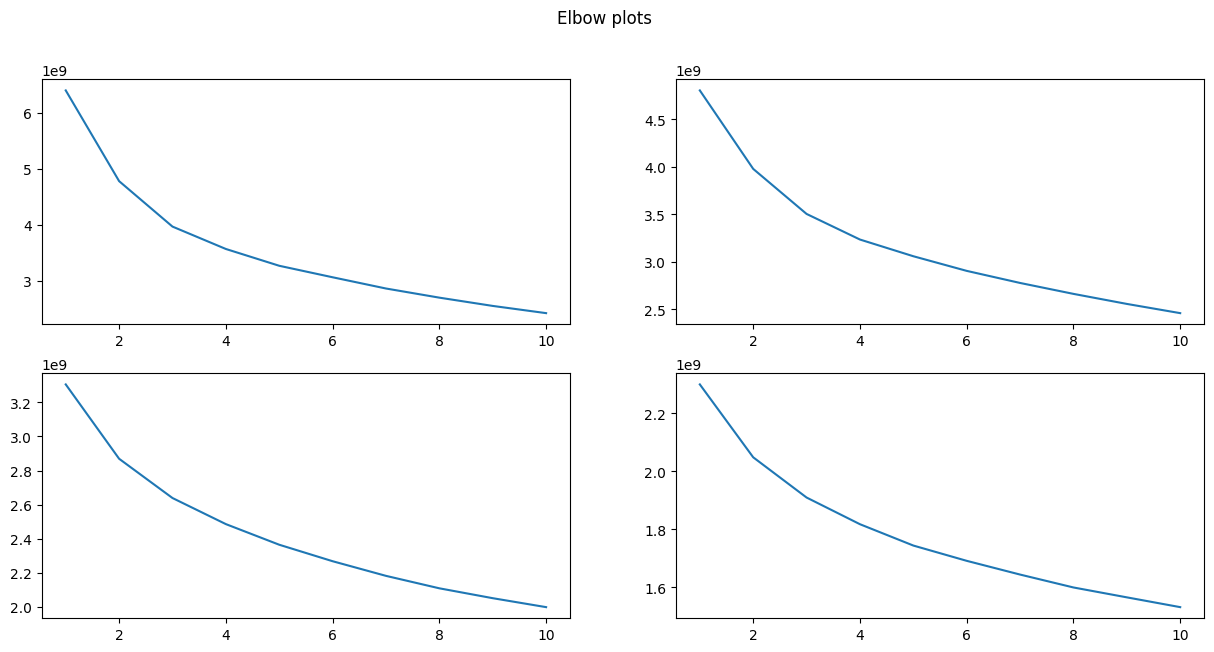

In [188]:
fig, ax = plt.subplots(2, len(variances)//2, figsize=(15,7))
fig.suptitle('Elbow plots')

for i, var in enumerate(variances):
    ax[i//2][i%2].plot(list(range(1,11)), var)
plt.show()

the elbow is near 3. we are going to try clusters of 3,4,5,7
Interestingly, the euclidean distance actually goes down with higher window sizees. We choose 2 and 5

In [177]:
n_clusters = [3,4,5,7] 
window_size = [2,5]

centered_vectors_rast = [ [ v.vectorize() for v in centered_vectors[w] ] for w in window_size ]
# Calculate Euclidean Distance between all pairs of sentences
euclidean_dists = [ euclidean_distances(v_r) for v_r in centered_vectors_rast ]

# Apply K-Means clustering



kmeans = [ KMeans(n_clusters=n_c, n_init=15, random_state=69) for n_c in n_clusters ]
cluster_labels = [ km.fit_predict(euclidean_dists[]) for i, km in enumerate(kmeans) ]
#cluster_centroids = [ centered_vectors[centered_vectors_rast.index(centroid)]
#                      for centroid in kmeans.cluster_centers_ ]

In [178]:
# Put each vector into its respective cluster
cluster_vectors = [ [] for _ in range(n_clusters) ]
for i, label in enumerate(cluster_labels):
    cluster_vectors[label].append(centered_vectors[window_size][i])

In [179]:
closest_point = euclidean_distances(euclidean_dists, [kmeans.cluster_centers_[0]]).flatten()
index = np.where(closest_point == closest_point.min())[0][0]
print(index)

print(kmeans.cluster_centers_[0])
print(closest_point)
print(closest_point[index])
print(centered_vectors_rast[index])

389
[30.62271149 35.44799736 47.25643254 ... 43.54247907 45.13410692
 39.23637094]
[ 705.19373521  810.47502468 1462.69267373 ... 1003.10956424 1414.18289897
 1130.63559548]
390.7635737009018
[19, 15, 35, 18, 26, 22, 3]


In [180]:
# Get most average sentence by finding the most common tags
def get_average_sentence(sentences: List[Sentence]):
    all_terms = [ [tag] for tag in sentences[0].morph ] 
    for s in sentences[1:]:
        for i, tag in enumerate(s.morph):
            all_terms[i].append(tag)
    return [ max(set(pos), key=pos.count) for pos in all_terms ]

for cluster_i, vectors in enumerate(cluster_vectors):
    print(f"Cluster {cluster_i} - {len(vectors)} sentences:")
    print(f"Most average tags: {get_average_sentence(vectors)}")
    # print(f"Centroid: {cluster_centroids[cluster_i]}")
    for s in vectors[0:10]:
        print(s.morph)
        print("Rough position: " + s.text)
    print("\n")

    #print(f"Cluster {cluster_id} - {len(sentences_words)} sentences (Words):")
    # for sentence in sentences_words[100:110]:
    #for sentence in sentences_words[0:10]:
    #    print(sentence)
    #print("\n")

Cluster 0 - 1621 sentences:
Most average tags: [<POS.NN: 36>, <POS.IN: 17>, <POS.VB: 12>, <POS.RP: 18>, <POS.COMMA: 41>, <POS.IN: 17>, <POS.DT: 3>]
[<POS.IN: 17>, <POS.RB: 19>, <POS.VB: 12>, <POS.RP: 18>, <POS.NN: 36>, <POS.NNS: 35>, <POS.IN: 17>]
Rough position: than just send out marketing people to knock on
[<POS.COMMA: 41>, <POS.VBG: 13>, <POS.PRP: 5>, <POS.RP: 18>, <POS.IN: 17>, <POS.DT: 3>, <POS.DT: 3>]
Rough position: sealing it off from the the rest of the
[<POS.IN: 17>, <POS.PRP: 5>, <POS.VBP: 14>, <POS.RP: 18>, <POS.PERIOD: 40>, <POS.UH: 29>, <POS.PERIOD: 40>]
Rough position: you come over. yeah. You know ?
[<POS.JJ: 25>, <POS.IN: 17>, <POS.VB: 12>, <POS.RP: 18>, <POS.RB: 19>, <POS.VBG: 13>, <POS.DT: 3>]
Rough position: to get by just running a business. "
[<POS.CC: 26>, <POS.VBP: 14>, <POS.VBN: 16>, <POS.RP: 18>, <POS.IN: 17>, <POS.VB: 12>, <POS.PRP: 5>]
Rough position: and have come down to save them.
[<POS.NN: 36>, <POS.IN: 17>, <POS.VB: 12>, <POS.RP: 18>, <POS.NNP: 37>, <

ValueError: 'c' argument has 7899 elements, which is inconsistent with 'x' and 'y' with size 4887.

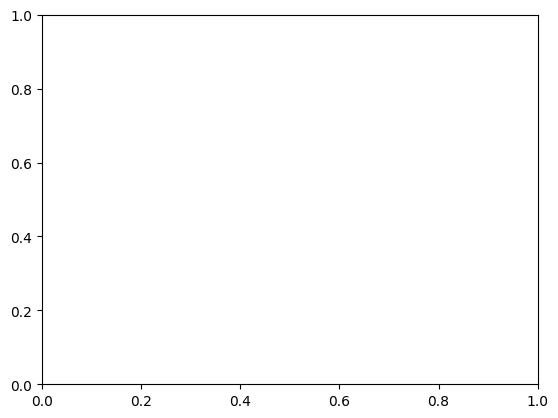

In [189]:
tsne = TSNE(n_components=2, perplexity=30, random_state=69)

tsne_res = tsne.fit_transform(euclidean_dists)

# Visualize the clusters using scatter plot
plt.scatter(tsne_res[:, 0], tsne_res[:, 1], c=cluster_labels, cmap='viridis')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()